In [27]:
import hnswlib
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import scipy.sparse
from modules import network,mlp
from utils import yaml_config_hook,save_model
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [28]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [31]:
gene_counts=np.arange(start=100,stop=10001,step=100)
print(gene_counts)
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
y_ndarray = np.expand_dims(y, axis=1)
y_count=np.zeros(args.classnum+1)
for i in range (0,args.classnum):
    y_count[i+1]=y_ndarray[y_ndarray==(i+1)].size

[  100   200   300   400   500   600   700   800   900  1000  1100  1200
  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400
  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600
  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800
  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000
  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200
  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400
  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600
  9700  9800  9900 10000]


In [50]:
correct_history=[]
for i in gene_counts:
    sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
    annoData = pd.read_table('data/annoData.txt')
    y = annoData["cellIden"].to_numpy()
    high_var_gene = i
    # normlization and feature selection
    adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
    sc.pp.filter_genes(adataSC, min_cells=10)
    adataSC.raw = adataSC
    sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
    sc.pp.normalize_total(adataSC, target_sum=1e4)
    sc.pp.log1p(adataSC)
    adataNorm = adataSC[:, adataSC.var.highly_variable]
    dataframe = adataNorm.to_df()
    x_ndarray = dataframe.values.squeeze()
    y_ndarray = np.expand_dims(y, axis=1)
    # print(x_ndarray.shape)

    index=np.where(y_ndarray.squeeze()==3)
    x_3 =x_ndarray[index]

    index=np.where(y_ndarray.squeeze()==8)
    x_8 =x_ndarray[index]

    index=np.where(y_ndarray.squeeze()==10)
    x_10 =x_ndarray[index]

    index=np.where(y_ndarray.squeeze()==11)
    x_11 =x_ndarray[index]

    index=np.where(y_ndarray.squeeze()==12)
    x_12 =x_ndarray[index]

    index=np.where(y_ndarray.squeeze()==13)
    x_13 =x_ndarray[index]

    index=np.where(y_ndarray.squeeze()==14)
    x_14 =x_ndarray[index]

    num_elements=len(x_ndarray)
    n=hnswlib.Index(space='cosine',dim=i)
    n.init_index(max_elements=num_elements, ef_construction=100, M=16)
    n.set_ef(100)
    n.set_num_threads(4)
    n.add_items(x_ndarray)

    incorrect_3=0
    for i in x_3:
        label,distance=n.knn_query(i,k=10)
        incorrect=np.where(y_ndarray[label.squeeze()]!=3)[0].shape[0]
        incorrect_3+=incorrect

    incorrect_8=0
    for i in x_8:
        label,distance=n.knn_query(i,k=10)
        incorrect=np.where(y_ndarray[label.squeeze()]!=8)[0].shape[0]
        incorrect_8+=incorrect
        
    incorrect_10=0
    for i in x_10:
        label,distance=n.knn_query(i,k=10)
        incorrect=np.where(y_ndarray[label.squeeze()]!=10)[0].shape[0]
        incorrect_10+=incorrect

    incorrect_11=0
    for i in x_11:
        label,distance=n.knn_query(i,k=10)
        incorrect=np.where(y_ndarray[label.squeeze()]!=11)[0].shape[0]
        incorrect_11+=incorrect

    incorrect_12=0
    for i in x_12:
        label,distance=n.knn_query(i,k=10)
        incorrect=np.where(y_ndarray[label.squeeze()]!=12)[0].shape[0]
        incorrect_12+=incorrect

    incorrect_13=0
    for i in x_13:
        label,distance=n.knn_query(i,k=10)
        incorrect=np.where(y_ndarray[label.squeeze()]!=13)[0].shape[0]
        incorrect_13+=incorrect

    incorrect_14=0
    for i in x_14:
        label,distance=n.knn_query(i,k=10)
        incorrect=np.where(y_ndarray[label.squeeze()]!=14)[0].shape[0]
        incorrect_14+=incorrect

    incorrect_sum=[incorrect_3/(9*y_count[3]),incorrect_8/(9*y_count[8]),incorrect_10/((9*y_count[10])),incorrect_11/(9*y_count[11]),incorrect_12/(9*y_count[12]),incorrect_13/(9*y_count[13]),incorrect_14/(9*y_count[14])]
    print(incorrect_sum)
    correct_history.append(incorrect_sum)
    
correct_history=np.array(correct_history)
print(correct_history.shape)
    

[0.3016623674405274, 0.2037037037037037, 0.022222222222222223, 0.29333333333333333, 0.1791907514450867, 0.5555555555555556, 0.746031746031746]
[0.09764020254132035, 0.21604938271604937, 0.00404040404040404, 0.07555555555555556, 0.08477842003853564, 0.3247863247863248, 0.7619047619047619]
[0.06668577433839687, 0.20987654320987653, 0.00202020202020202, 0.0, 0.1111111111111111, 0.2222222222222222, 0.4603174603174603]
[0.0530237890513041, 0.21604938271604937, 0.00202020202020202, 0.044444444444444446, 0.11946050096339114, 0.17094017094017094, 0.6190476190476191]
[0.04533295117989873, 0.19135802469135801, 0.00202020202020202, 0.0, 0.10725754656390495, 0.1282051282051282, 0.6984126984126984]
[0.031527658354829464, 0.19135802469135801, 0.00202020202020202, 0.0, 0.12010276172125883, 0.11965811965811966, 0.3333333333333333]
[0.02885258431260151, 0.2654320987654321, 0.00202020202020202, 0.04, 0.11496467565831728, 0.1282051282051282, 0.5396825396825397]
[0.025604280118467566, 0.24074074074074073,

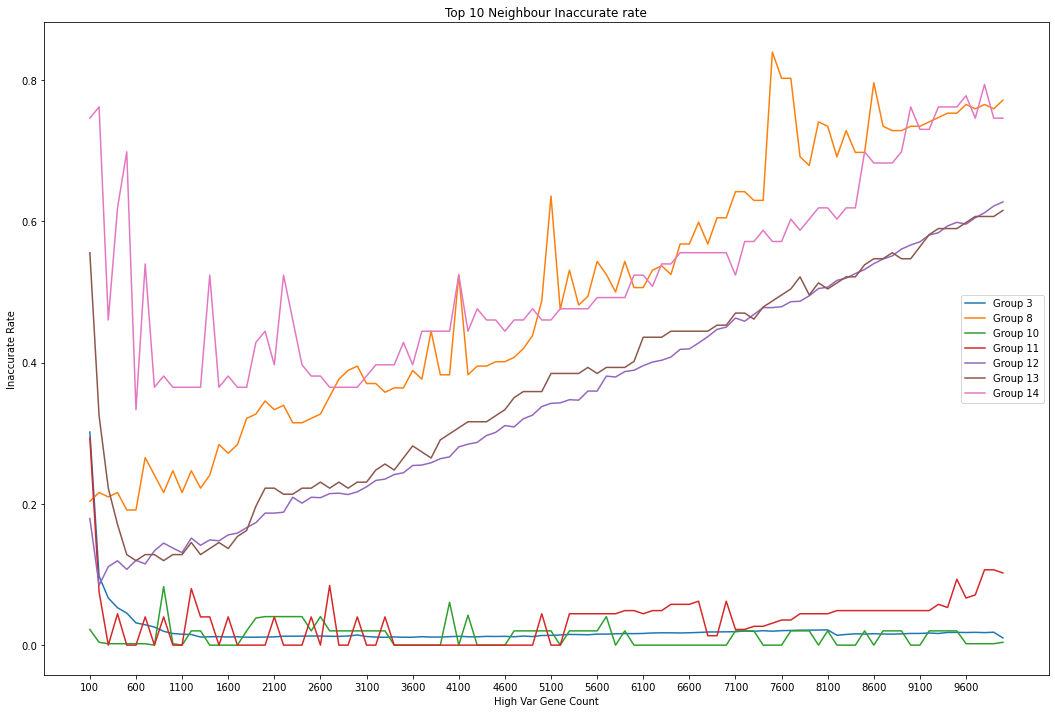

In [56]:
plt.figure(figsize=(18, 12))
plt.plot(gene_counts,correct_history[:,0],label='Group 3')
plt.plot(gene_counts,correct_history[:,1],label='Group 8')
plt.plot(gene_counts,correct_history[:,2],label='Group 10')
plt.plot(gene_counts,correct_history[:,3],label='Group 11')
plt.plot(gene_counts,correct_history[:,4],label='Group 12')
plt.plot(gene_counts,correct_history[:,5],label='Group 13')
plt.plot(gene_counts,correct_history[:,6],label='Group 14')
plt.xlabel('High Var Gene Count')
plt.xticks(gene_counts[0:-1:5])
plt.ylabel('Inaccurate Rate')
plt.legend()
plt.title('Top 10 Neighbour Inaccurate rate')
plt.show()